In [1]:
from network_evaluation_tools import gene_conversion_tools as gct
from network_evaluation_tools import data_import_tools as dit
import pandas as pd
import itertools
import time
import matplotlib.pyplot as plt

In [2]:
wd = '/cellar/users/snwright/Data/Network_Analysis/'

# Version 2.0
## Load Mentha Raw Data
#### Source (MITAB): http://mentha.uniroma2.it/doDownload.php?file=2017-06-12_MITAB-2.5.zip
Downloaded: Dec 22, 2021
Last Updated: Dec 20, 2021  
Notes for processing: This is the file should contain only human-human protein interactions but this should be checked and filtered if needed.  
A Note about scoring: Mentha does have a score assigned for each interaction called the 'mentha-score', this will be the score we use to filter the network.

In [3]:
Mentha_Raw_v2 = pd.read_csv(wd+'Network_Data_Raw/Mentha/2021-12-20_MITAB-2.5.zip', sep=';')
print('Raw edge count in Mentha:', len(Mentha_Raw_v2))

Raw edge count in Mentha: 741337


In [4]:
Mentha_Raw_v2.head()

,Protein A,Gene A,Taxon A,Protein B,Gene B,Taxon B,Score,PMID
0,P14625,HSP90B1,9606,O95466,FMNL1,9606,0.126,23182705
1,Q86U42,PABPN1,9606,P26368,U2AF2,9606,0.126,26641092
2,Q9I7T7,Q9I7T7,7227,P10987,ACT5C,7227,0.354,14605208
3,Q9H7D7,WDR26,9606,Q8IVV7,GID4,9606,0.332,unassigned1312 27173435
4,P16070,CD44,9606,O95466,FMNL1,9606,0.126,23182705


In [5]:
# Keep only human-human interactions
Mentha_Human_only_v2 = Mentha_Raw_v2[(Mentha_Raw_v2["Taxon A"]==9606) & (Mentha_Raw_v2["Taxon B"]==9606)]
print('Human-Human only interactions in Mentha:', len(Mentha_Human_only_v2))

Human-Human only interactions in Mentha: 340916


In [6]:
Human_Mentha_Genes_v2 = list(set(Mentha_Human_only_v2["Protein A"]).union(set(Mentha_Human_only_v2["Protein B"])))

## Convert Network Genes to symbol from UniProt Accession ID

In [7]:
# Construct list of genes to be submitted to MyGene.Info API (remove all genes with 'intact' prefix)
query_string_v2, valid_genes_v2, invalid_genes_v2 = gct.query_constructor(Human_Mentha_Genes_v2)

19300 Valid Query Genes
0 Invalid Query Genes


In [8]:
# Original 18932 matched query results
# Set scopes (gene naming systems to search)
scopes = "uniprot"

# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"

# Query MyGene.Info
match_list_v2 = gct.query_batch(query_string_v2, scopes=scopes, fields=fields)


100%|██████████| 20/20 [00:15<00:00,  1.32it/s]

19581 Matched query results
Batch query complete: 15.14 seconds


In [39]:
matched_df_v2 = pd.DataFrame.from_dict(match_list_v2)
unmatched_ids_v2 = matched_df_v2[matched_df_v2.notfound==True]["query"].tolist()
print("IDs not matched by mygeneinfo:", len(unmatched_ids_v2))

IDs not matched by mygeneinfo: 1405


In [41]:
uniprot_results_v2 = gct.query_uniprot(unmatched_ids_v2, target_fmt=["P_ENTREZGENEID", "GENENAME", "ACC"], output_fmt='tab', return_as_dict=True)

In [42]:
match_list_v2 = match_list_v2 + uniprot_results_v2

In [43]:
# Original 1198 without full matching results, 207 with multiple matches
match_table_trim_v2, query_to_symbol_v2, query_to_entrez_v2 = gct.construct_query_map_table(pd.DataFrame.from_dict(match_list_v2), valid_genes_v2)

Number of genes with multiple matches: 4731
Number of unmatched genes: 1405
Number of fully matched genes: 18010
Number of partially matched genes: 1290


## Construct Converted Network

In [44]:
query_edgelist_v2 = Mentha_Human_only_v2[["Protein A", "Protein B", "Score"]].drop_duplicates().values.tolist()

In [45]:
# Convert network edge list to symbol
Mentha_edgelist_symbol_v2 = gct.convert_edgelist(query_edgelist_v2, query_to_symbol_v2, weighted=True)

In [46]:
 
# Filter converted edge list
Mentha_edgelist_symbol_filt_v2 = gct.filter_converted_edgelist(Mentha_edgelist_symbol_v2, weighted=True)

340916 input edges
3161 self-edges removed
1357 edges with un-mapped genes removed
5250 duplicate edges removed
Edge list filtered: 0.83 seconds
331148 Edges remaining


In [47]:
# Save filtered, converted edge list to file
gct.write_edgelist(Mentha_edgelist_symbol_filt_v2, wd+'/Processed_Data/Network_SIFs_Symbol/Mentha_Symbol_2021.sif', binary=False)

Edge list saved: 0.57 seconds


In [48]:
# Create filtered network
Mentha90_edgelist_v2 = dit.filter_weighted_network_sif(wd+'/Processed_Data/Network_SIFs_Symbol/Mentha_Symbol_2021.sif', nodeA_col=0, nodeB_col=1, score_col=2, 
                                                    q=0.9, delimiter='\t', verbose=True, save_path=wd+'/Processed_Data/Network_SIFs_Symbol/Mentha90_Symbol_2021.sif')

90.0% score: 0.454
25265 / 331148 edges retained


# Version 1.0 (original)
## Load Mentha Raw Data
#### Source (MITAB): http://mentha.uniroma2.it/doDownload.php?file=2017-06-12_MITAB-2.5.zip
Downloaded: June 15, 2017  
Last Updated: June 12, 2017  
Notes for processing: This is the file should contain only human-human protein interactions but this should be checked and filtered if needed.  
A Note about scoring: Mentha does have a score assigned for each interaction called the 'mentha-score', this will be the score we use to filter the network.

In [16]:
Mentha_Raw = pd.read_csv(wd+'Network_Data_Raw/Mentha/mentha_2017_06_12', sep='\t', header=None)
print('Raw edge count in Mentha:', len(Mentha_Raw))

Raw edge count in Mentha: 1114184


In [17]:
# Keep only human-human interactions
Mentha_Human_only = Mentha_Raw[(Mentha_Raw[9]=='taxid:9606(Homo sapiens)') & (Mentha_Raw[10]=='taxid:9606(Homo sapiens)')]
print('Human-Human only interactions in Mentha:', len(Mentha_Human_only))

Human-Human only interactions in Mentha: 531726


In [18]:
# Extract gene list
Human_Mentha_Genes = list(set(Mentha_Human_only[0]).union(set(Mentha_Human_only[1])))

## Convert Network Genes to symbol from UniProt Accession ID

In [19]:
# Construct list of genes to be submitted to MyGene.Info API (remove all genes with 'intact' prefix)
query_string, valid_genes, invalid_genes = gct.query_constructor(Human_Mentha_Genes)

18626 Valid Query Genes
0 Invalid Query Genes


In [20]:
# Original 18932 matched query results
# Set scopes (gene naming systems to search)
scopes = "uniprot"

# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"

# Query MyGene.Info
match_list = gct.query_batch(query_string, scopes=scopes, fields=fields)


100%|██████████| 19/19 [00:15<00:00,  1.25it/s]

18885 Matched query results
Batch query complete: 15.23 seconds


In [21]:
matched_df = pd.DataFrame.from_dict(match_list)
unmatched_ids = matched_df[matched_df.notfound==True]["query"].tolist()
print("IDs not matched by mygeneinfo:", len(unmatched_ids))

IDs not matched by mygeneinfo: 1297


In [22]:
uniprot_results = gct.query_uniprot(unmatched_ids, target_fmt=["P_ENTREZGENEID", "GENENAME", "ACC"], output_fmt='tab', return_as_dict=True)

In [23]:
match_list = match_list + uniprot_results

Next steps:
* Make sure incomplete versions are replaced in the original match list, otherwise they will all still show up as incomplete/duplicate.

In [24]:
# Original 1198 without full matching results, 207 with multiple matches
match_table_trim, query_to_symbol, query_to_entrez = gct.construct_query_map_table(pd.DataFrame.from_dict(match_list), valid_genes)

Number of genes with multiple matches: 4632
Number of unmatched genes: 1297
Number of fully matched genes: 17487
Number of partially matched genes: 1139


## Construct Converted Network

In [32]:
query_edgelist = Mentha_Human_only[[0, 1, 14]].drop_duplicates().values.tolist()

In [33]:
# Format edge list by removing 'uniprot:' prefix from all interactors
query_edgelist_fmt = [[gct.get_identifier_without_prefix(edge[0]), gct.get_identifier_without_prefix(edge[1]), float(edge[2].split(':')[-1])] for edge in query_edgelist]

In [34]:
# Convert network edge list to symbol
Mentha_edgelist_symbol = gct.convert_edgelist(query_edgelist_fmt, query_to_symbol, weighted=True)

In [35]:
# Original 
# 327857 input edges
# 3247 self-edges removed
# 8219 edges with un-mapped genes removed
# 53515 duplicate edges removed
# Edge list filtered: 1.61 seconds
# 262876 Edges remaining
## Why such a large change in duplicate edge removal??
# Filter converted edge list
Mentha_edgelist_symbol_filt = gct.filter_converted_edgelist(Mentha_edgelist_symbol, weighted=True)

327857 input edges
2982 self-edges removed
1660 edges with un-mapped genes removed
56446 duplicate edges removed
Edge list filtered: 0.71 seconds
266769 Edges remaining


In [36]:
# Save filtered, converted edge list to file
gct.write_edgelist(Mentha_edgelist_symbol_filt, wd+'/Processed_Data/Network_SIFs_Symbol/Mentha_Symbol_2017.sif', binary=False)

Edge list saved: 0.54 seconds


In [37]:
# Original
# 90.0% score: 0.454
# 22886 / 262876 edges retained
# Create filtered network
Mentha90_edgelist = dit.filter_weighted_network_sif(wd+'/Processed_Data/Network_SIFs_Symbol/Mentha_Symbol_2017.sif', nodeA_col=0, nodeB_col=1, score_col=2, 
                                                    q=0.9, delimiter='\t', verbose=True, save_path=wd+'/Processed_Data/Network_SIFs_Symbol/Mentha90_Symbol_2017.sif')

90.0% score: 0.454
23163 / 266769 edges retained


In [38]:
# Create filtered network
Mentha90_edgelist = dit.filter_weighted_network_sif(wd+'/Processed_Data/Network_SIFs_Symbol/Mentha_Symbol_2017.sif', nodeA_col=0, nodeB_col=1, score_col=2, 
                                                    q=0.9, delimiter='\t', verbose=True, save_path=wd+'/Processed_Data/Network_SIFs_Symbol/Mentha90_Symbol_2017.sif')

90.0% score: 0.454
23163 / 266769 edges retained


# Changes

**Data Structure**  
Data provided now contains a header line:  
`Protein A	Gene A	Taxon A	Protein B	Gene B	Taxon B	Score	PMID`  

Data no longer contains:
* Source dataset IDs
* psi-mi


In [54]:
stats = pd.DataFrame({"v1":[1114184, 531726, 310492], 
                           "v2":[741337, 340916, 325480]},
                           index=["input", "human_human", "filtered"])

In [49]:
nodes_v1 = set(np.array(Mentha_edgelist_symbol_filt)[:, 0]).union(set(np.array(Mentha_edgelist_symbol_filt)[:, 1]))
nodes_v2 = set(np.array(Mentha_edgelist_symbol_filt_v2)[:, 0]).union(set(np.array(Mentha_edgelist_symbol_filt_v2)[:, 1]))


Text(0, 0.5, 'Number of nodes')

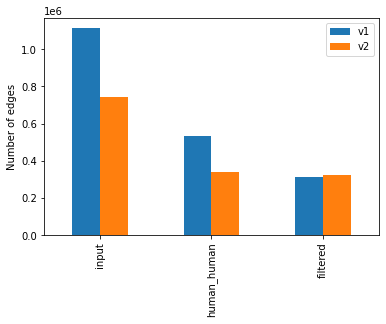

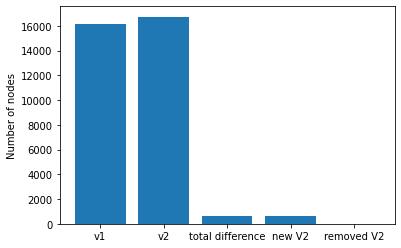

In [63]:
stats.plot.bar(ylabel="Number of edges")
plt.figure()
plt.bar(["v1", "v2", "total difference", "new V2", "removed V2"], [len(nodes_v1), len(nodes_v2), len(nodes_v2)-len(nodes_v1),
                                                           len(nodes_v2.difference(nodes_v1)), len(nodes_v1.difference(nodes_v2))])
plt.ylabel("Number of nodes")